In [1]:
import numpy as np

import ipdb
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class dynamical_system:
    '''
    A set of inheritable methods to solve dynamical systems
    '''
    def integrate(self,tinit, tmax, dt, x0,method='RK45'):
        '''
        Solves a differental equation from tinit to tmax and storing the 
        solution value dt intervals.
        
        Args: 
            tinit: inital time of the system
            tmax: final time of the system
            x0: initial value of the system
            method: numerical scheme to compute the solution
        
        Returns:
            sol: the solution from solve_ivp that contains integration parameters
        '''
        t_eval =  np.arange(tinit, tmax, dt)
        sol=solve_ivp(self.rhs, [tinit, tmax], x0, t_eval = t_eval,method='RK45')
        self.xs = (sol.y).T
        self.ts = sol.t
        return sol
    
    def trajectory_plot(self,ind=[0,1,2]):
        '''
        Three dimension plot of a cross section of phase space
        
        Args:
            ind: indices of the states used to generate the cross section
        '''
        fig=plt.figure()
        ax = fig.gca(projection='3d')
        #generate plot object
        ax.plot(self.xs[:,ind[0]],self.xs[:,ind[1]],self.xs[:,ind[2]])
        
        #label axes
        ax.set_xlabel('$x_'+str(ind[0])+'$')
        ax.set_ylabel('$x_'+str(ind[1])+'$')
        ax.set_zlabel('$x_'+str(ind[2])+'$')
        plt.show()
        
    def evolution_plot(self,ind=None,legnames=None):
        '''
        Plot of evolution of states with respect to time
        
        Args:
            ind: indices of the states plot evolution
        '''
        
        if (ind is not None):
            #generate plot object
            plt.plot(self.ts,self.xs[:,ind])
            #legend
            if (legnames is None):
                legnames = ['$x_' + str(i) + '$' for i in ind]
        else:
            #generate plot object
            plt.plot(self.ts,self.xs)
            #legend
            ind = (self.xs).shape[1]
            if (legnames is None):
                legnames = ['$x_' + str(i) + '$' for i in range(0,ind)]
            
            
        #label axes
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        
        plt.legend(legnames,loc="upper right")
        plt.show()

# Lorenz 96

In [3]:
class Lorenz96(dynamical_system):
    def __init__(self, N, F):
        '''
        creates a Lorenz class with N terms and forcing, F
        
        Args:
            N: number of terms in the dynamical system
            F: forcing term
        '''
        self.N = N
        self.F = F
    
    def rhs(self, t, x):
        '''
        Calculates dx/dt of the Lorenz equation at x and time = t.
        See https://en.wikipedia.org/wiki/Lorenz_96_model.
        
        Args:
            x: the state of the dynamical system at time t
            t: the current time of dynamical system
            
        Returns:
            dxdt: vector field at dxdt
        '''
        #number of terms in the dynamical system
        N = self.N
        
        #Forcing term
        F = self.F
        
        #initialize rhs vector
        dxdt = np.zeros(N)
        
        #edge cases
        dxdt[0] =  (x[1] - x[-2])*x[-1] - x[0] + F
        dxdt[1] =  (x[2] - x[-1])*x[0] - x[1] + F
        dxdt[N-1] =  (x[0] - x[N-3])*x[N-2] - x[N-1] + F

        #non-edge cases
        if (N > 3):
            dxdt[2:(N-1)] =  (x[3:N] - x[:(N-3)])*x[1:(N-2)] - x[2:(N-1)] + F
        
        return dxdt

In [4]:
# these are our constants
N = 5  # number of variables
F = 8  # forcing
x0 = F*np.ones(N) # initial state (equilibrium)
x0[2] += 0.01 # add small perturbation to 20th variable
tinit = 0
tmax = 10.0
dt = 0.01

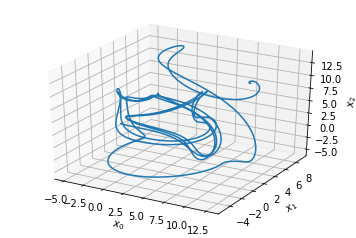

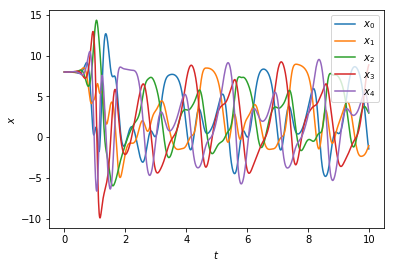

In [5]:
lorenz96 = Lorenz96(N,F)
sol = lorenz96.integrate(tinit,tmax, dt ,x0)
lorenz96.trajectory_plot()
lorenz96.evolution_plot()

# Kuramoto Models

In [6]:
class Kuramoto(dynamical_system):
    def __init__(self, N, K, omega):
        '''
        creates a Kuramoto class with N oscillators, coupling term K
        and natural frequency, omega
        
        Args:
            N: number of oscillators
            K: number
        '''
        #number of oscillators
        self.N = N
        #coupling term
        self.K = K
        #natural frequency
        self.omega = omega
        
    def rhs(self,t,x):
        '''
        Calculates dx/dt of the Kuramoto equation at state, x, and time, t.
        See https://en.wikipedia.org/wiki/Lorenz_96_model.
        
        Args:
            x: the state of the dynamical system at time t
            t: the current time of dynamical system
            
        Returns:
            dxdt: the vector field at x, t.
        '''
        #natural frequency
        omega = self.omega
        #number of oscillators
        N = self.N
        #coupling term
        K = self.K
        
        #calculate dxdt
        temp = np.reshape(x, (N,-1))
        xmat = np.repeat(temp,N,axis=1)
        dxdt = omega + (K/N)*np.sum(np.sin(xmat - x),axis=0)
        return dxdt

In [7]:
# these are our constants
N = 8  # number of variables
K = 10.0 #coupling
omega =  np.pi*np.random.uniform(size=N)   # natural frequency
theta0 = 2*np.pi*np.random.uniform(size=N) # initial state 
tinit = 0.0
tmax = 10.0
dt =  0.001

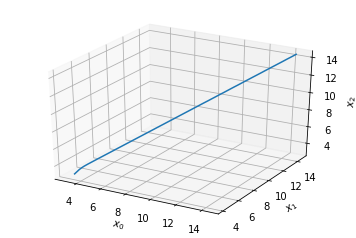

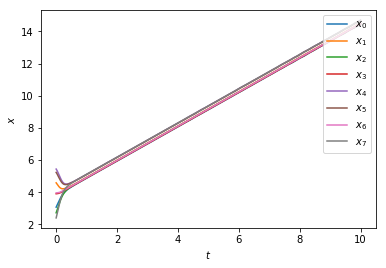

In [8]:
kuramoto = Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)
kuramoto.trajectory_plot()
kuramoto.evolution_plot()

# Weiner Processes

In [9]:
class sdes:
    def __init__(self, a_fun, b_fun):
        '''
        Creates an SDE of the form dX = a(X,t)dt + b(X,t)dW(t)
        
        Args:
           a_fun = a(X,t)
           b_fun = b(X,t)
        '''
        self.a_fun = a_fun
        self.b_fun = b_fun
    
    def euler_maruyama(self,tinit,x_init,tmax,N):
        '''
        Implements Euler Maruyama for an SDE. 
        See https://en.wikipedia.org/wiki/Euler-Maruyama_method
        
        Args: 
            tinit: initial time
            x_init: inital state of x
            tmax: final time
            N: number of time points
            
        Returns:
            X at time points, tinit + i*(tmax-tinit)/N.
        '''
        a_fun = self.a_fun 
        b_fun = self.b_fun
        
        dt = (tmax-tinit)/(N-1)
        dW = np.random.normal(loc=0.0, scale=np.sqrt(dt),size=N-1)
        X = np.zeros(N)
        t = np.zeros(N)
        X[0] = x_init
        t[0] = tinit
        for i in range(1,N):
            X[i] = X[i-1] + a_fun(X[i-1])*dt + b_fun(X[i-1])*dW[i-1] 
            t[i] = t[i-1] + dt
        self.Xs = X
        self.ts = t
        return [self.ts,self.Xs]
    
    def plot(self):
        '''
        Plots the solution X(t)
        '''
        plt.plot(self.ts,self.Xs)
        plt.xlabel('$t$')
        plt.ylabel('$X$')
        plt.show()

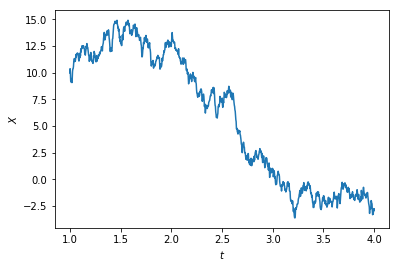

In [10]:
def a_fun(X):
    return -2
def b_fun(X):
    return 5

sodes=sdes(a_fun,b_fun)
sol = sodes.euler_maruyama(1.0,10.0,4.0,1000)
sodes.plot()

# Simple Enzymatic Reaction

Dynamical system for the simple enzymatic reaction:

$X_1 + X_2\rightarrow^{k_1} X_1E_1 \rightarrow^{k_3} X_2E_1 \rightarrow^{k_5} X_2 + E_1$


$X_1 + X_2\leftarrow^{k_2} X_1E_1 \leftarrow^{k_4} X_2E_1 \leftarrow^{k_6} X_2 + E_1$

In [11]:
class enzymatic_reaction(dynamical_system):
    def __init__(self,S,reaction_rates):
        '''
        creates a dynamical system for a simple enzymatic reaction
        with reaction rates, reaction_rates.
        '''
        self.reaction_rates = reaction_rates
        self.S = S

    def get_rates_vector(self,x):
        '''
        Calculates the flux of each chemical reaction
        
        Args:
            x: the concentration of each compound at time t
            t: the current time of dynamical system
            
        Returns:
            rates_vector: vector of the flux of each chemical reaction
        '''
        
        #get reaction rations
        S = self.S
        num_reactants, num_reactions = S.shape
        reaction_rates = self.reaction_rates 
        
        #determine mass action kinetic rate vector
        #determine which entries of S should contribute
        #to entry in rates vector
        bool_ind = S <0
        rates_vector = np.zeros(num_reactions)
        
        # row and column indices that have a negative
        # entries in S
        
        neg_indexes = np.column_stack(np.where(bool_ind))
        
        for i in range(0,num_reactions):
            # determine flux for each reaction
            
            # entries of neg_indexes that are in the ith column
            cols_with_ind = (neg_indexes[:,1] == i)
            
            # the row entry of each element in neg_indexes 
            # that are in the ith column of S_f_b
            row_indices = neg_indexes[cols_with_ind,:][:,0]
            
            # iterating over row indices of neg_indexes with
            # entries ith column of S_f_b
            
            # Computing the flux by multiplying the reactants
            # associated with row_indices together with its
            # rate constant
            prod = 1
            
            for j in row_indices:
                prod = prod*x[j]
            rates_vector[i] = reaction_rates[i]*prod
            
        return rates_vector
    
    
    def rhs(self,t,x):
        '''
        Calculates dx/dt for the chemical reaction at
        state, x, and time, t.
        
        Args:
            x: current state
            t: time, t
        Returns:
            dxdt: the vector field at x(t)
        '''
        rates_vector = self.get_rates_vector(x)
        return np.dot(self.S,rates_vector)
    
    def gillespie_step(self,x):
        '''
        Implements the Gillespie Algorithm
        
        Args:
            x: current state
            
        Returns:
            tau: time step
            j: index of the reaction that has occurred
        '''
        # get reaction flux
        rates_vector = self.get_rates_vector(x)
        
        # generate two randum number
        
        U1,U2 = np.random.uniform(size=2)
        
        rates_sum = rates_vector.sum()
        
        # calculate time step
        tau = -np.log(U1)/rates_sum

        # determine j -- smallest index in the cumulative sum to be
        # greater than or equal to U2
        
        norm_rates = (1/rates_sum)*np.cumsum(rates_vector)
        bools_ind = (norm_rates >= U2)
        j =np.column_stack(np.where(bools_ind))[0]
        
        return tau,j
    
    def solve_markov_process(self,tinit, tmax, x0):
        '''
        Solves the stochastic chemical reaction from an initial state
        of x0
        
        Args:
            tinit: initial time
            tmax: maximum time
            x0: inital state
        '''
        #get stoichiometric matrix
        S = self.S
        
        #get initial states and time
        t = [tinit]
        tprev = tinit
        x = [x0]
        xprev = x0
        
        #solve for tprev < tmax
        while(tprev<tmax):
            #take a gillespie step
            tau, j = self.gillespie_step(xprev)
            
            #update
            tnew = tprev + tau
            xnew = xprev + (S[:,j].T).flatten()
            #if all updates are positive accept step
            if np.all(xnew > 0):
                t.append(tnew)
                x.append(xnew)

                tprev = tnew
                xprev = xnew
            
        self.ts = t
        self.xs = np.array(x)
        return [self.ts,self.xs] 
        
            
    
    def evolution_plot(self):
        legnames =  ['$[X_1]$','$[X_2]$',
                    '$[X_1E_1]$','$[X_2E_1]$',
                    '$[E_1]$']
        dynamical_system.evolution_plot(self,legnames=legnames)

In [12]:
S = np.array([[-1, 1, 0, 0, 0, 0],
              [ 0, 0, 0, 0, 1, -1],
              [ 1,-1,-1, 1, 0, 0],
              [ 0, 0, 1,-1,-1, 1],
              [-1, 1, 0, 0, 1,-1]])
reaction_rates =np.array([1.0,1.0,2.0,1.0,1.0,1.0])
tinit = 0.0
tmax = 100.0
dt = 0.01

x0 = np.array([1.0,1.0,1.0,1.0,1.0])

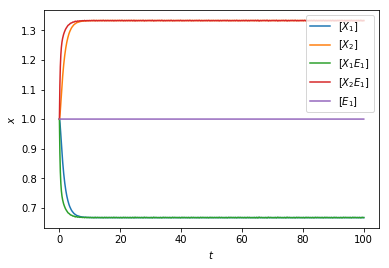

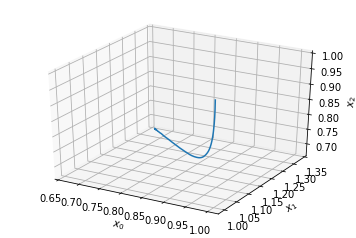

In [13]:
chemical_obj=enzymatic_reaction(S,reaction_rates)

sol = chemical_obj.integrate(tinit,tmax,dt,x0)
chemical_obj.evolution_plot()
chemical_obj.trajectory_plot()

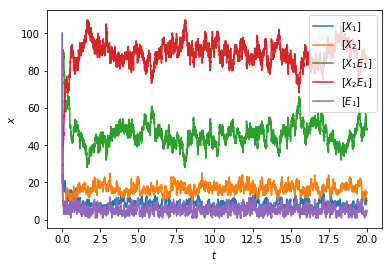

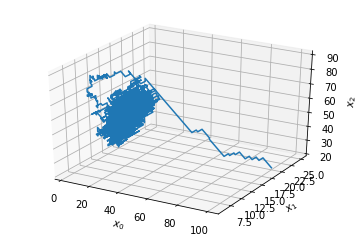

In [14]:
chemical_obj=enzymatic_reaction(S,reaction_rates)
sol = chemical_obj.solve_markov_process(tinit,20.0,np.array([100.0,20.0,20.0,20.0,100.0]))
chemical_obj.evolution_plot()
chemical_obj.trajectory_plot()

# Van der Pol Oscillator

In [15]:
class van_der_pol(dynamical_system):
    def __init__(self, mu):
        '''
        creates a Van der Pol oscillator class with damping constant, mu
        
        Args:
            mu: damping constant
        '''
        #number of oscillators
        self.mu = mu
        
    def rhs(self,t,x):
        '''
        Calculates dx/dt of a Van der Pol oscillator at state, x, and time, t.
        
        Args:
            x: the state of the dynamical system at time t
            t: the current time of dynamical system
            
        Returns:
            dxdt: the vector field at x, t.
        '''
        #natural frequency
        mu = self.mu
        dxdt = np.array([0.0,0.0])
        
        #calculate dxdt
        dxdt[0] = x[1]
        dxdt[1] = mu*x[1]*(1-x[0]**2) - x[0]
        
        return dxdt
    
    def trajectory_plot(self):
        '''
        2-D plot of phase space
        
        Args:
            ind: indices of the states used to generate the cross section
        '''
        fig=plt.figure()
        
        #generate plot object
        plt.plot(self.xs[:,0],self.xs[:,1])
        
        #label axes
        plt.xlabel('$x_'+str(0)+'$')
        plt.ylabel('$x_'+str(1)+'$')
        plt.show()
        

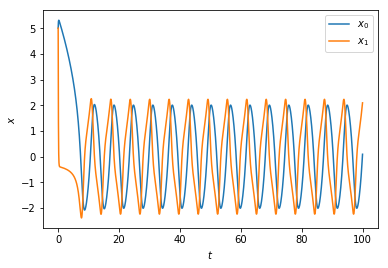

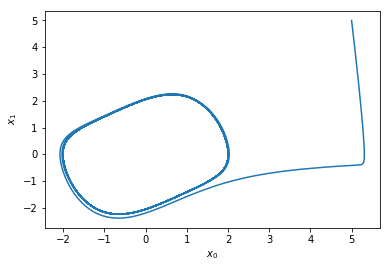

In [16]:
x0 = np.array([5.0, 5.0])
dt = 0.01
tmax = 100.0
vdp =van_der_pol(0.5)
sol = vdp.integrate(tinit,tmax,dt,x0)
vdp.evolution_plot()
vdp.trajectory_plot()